<IPython.core.display.Javascript object>


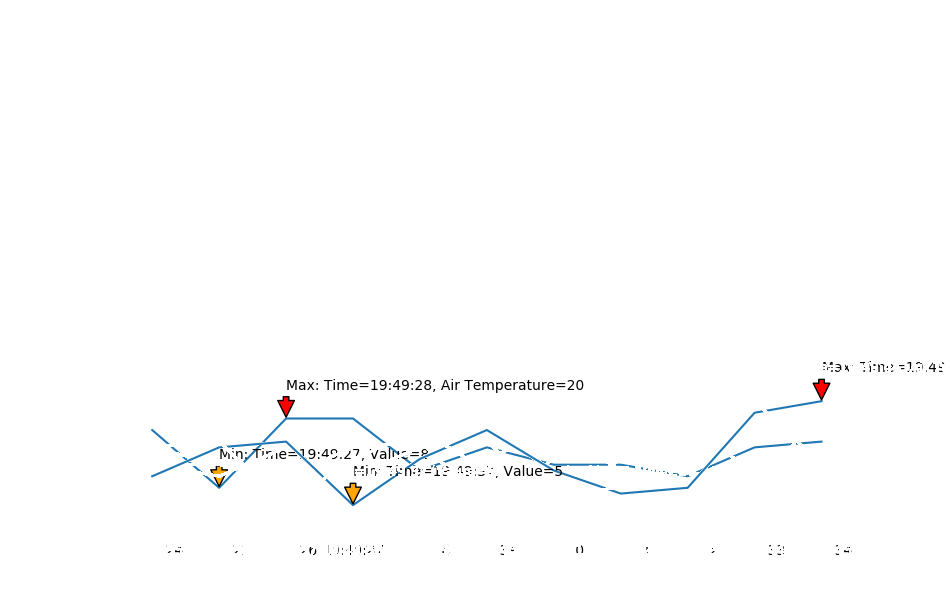

KeyboardInterrupt: 

In [7]:
# import statements
import json
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'Producer'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Air Temperature={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   #a = lambda x : loads(x.decode("utf-8")),
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Air Temperature')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer2, fig, ax):
#     for message in consumer2:
#         Data = json.loads(message.value.decode('utf-8'))
#         #pprint(Data)
#         print(type(Data.get("create_time")))
#         print(type(Data.get("data").get("air_temperature_celcius")))
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer2:
            #Data = message.value
            Data = json.loads(message.value.decode('utf-8')) # Get data
            x.append(Data.get("create_time")) # Using "time" as x
            y.append(Data.get("data").get("air_temperature_celcius")) # Using air temperature as y
            # print(y)
            # we start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time')
                ax.set_ylabel('Air Temperature')
                ax.set_ylim(0,80) 
                ax.set_yticks([0,20,40,60,80])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer2 = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer2, fig, ax)
    
    

/home/student/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  if sys.path[0] == '':
/home/student/.local/lib/python3.5/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


<IPython.core.display.Javascript object>


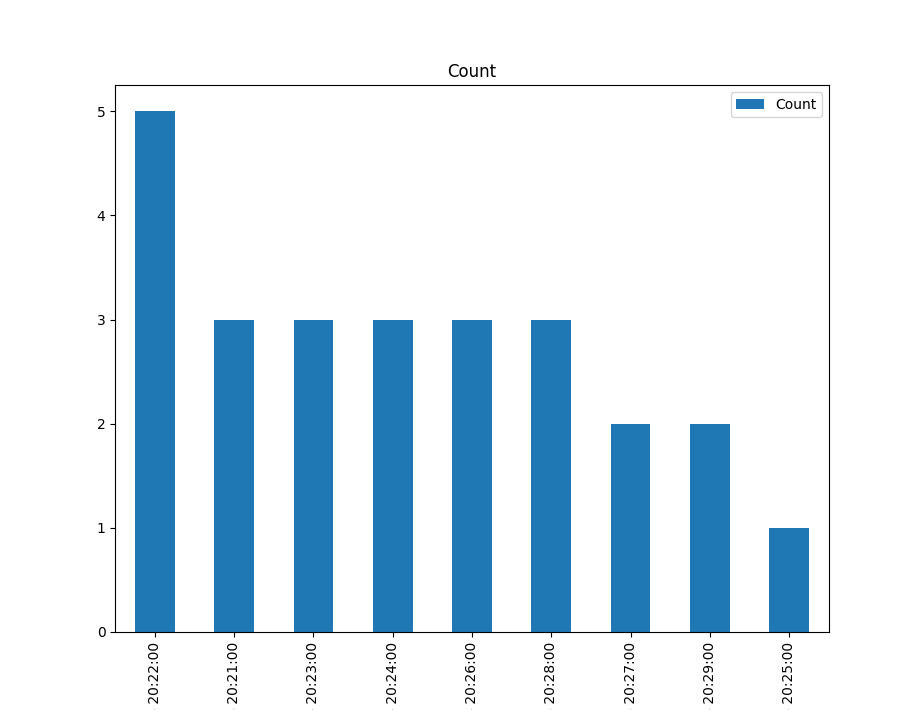

,time,Count
1,2019-05-24 20:22:00,5
0,2019-05-24 20:21:00,3
2,2019-05-24 20:23:00,3
3,2019-05-24 20:24:00,3
5,2019-05-24 20:26:00,3
7,2019-05-24 20:28:00,3
6,2019-05-24 20:27:00,2
8,2019-05-24 20:29:00,2
4,2019-05-24 20:25:00,1


In [14]:
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
client = MongoClient()
db = client.fit5148_assignment_db
fire_data = db.fire_data
df = pd.DataFrame(fire_data.find({"fire":"true"})) # Collecting the fire records from mongodb
df['time']=pd.to_datetime(df['time'])
df.index = df['time'].tolist() # Using time as index
al = {'fire':{'Count':'count'}} # set the count
fire = df.groupby(pd.TimeGrouper('1Min')).agg(al) # Using the time inversal to group the records
fire.reset_index(level=0, inplace=True)
fire.columns = fire.columns.droplevel(0) 
fire.rename(columns = {'':'time'},inplace=True) #Rename the column name for plot
fire_top10 = fire.sort_values('Count',ascending = False).head(10) # showing top10 fires and sort in order
barChart = fire_top10.plot.bar(x='time', y='Count',legend='false',subplots=True)
fire_top10

In [10]:
from pymongo import MongoClient
import gmplot
client = MongoClient()
db = client.fit5148_assignment_db
fire_data = db.fire_data
# Preparing the data for plotting
gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 8)
fireList = []

# Looping through all the data
for row in fire_data.find():
    # Checking if the fire spot is available
    if row['fire'] == 'true':
        # Adding the latitude and longitude to the list of unoccupied spots
        d = {}  # adding information for markers
        d['surface_temperature_celcius']=(row.get('surface_temperature_celcius'))
        d['confidence']=(row.get('confidence'))
        d['air_temperature_celcius']=(row.get('air_temperature_celcius'))
        d['relative_humidity']=(row.get('relative_humidity'))
        description = str(d)
        # Adding markers to the Google Maps
        gmap.marker(row.get('latitude'), row.get('longitude'),title = (description))


In [11]:
import webbrowser
# Drawing the map
gmap.draw("fire.html")
webbrowser.open_new("fire.html")

True